In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
warnings.filterwarnings("ignore")
%matplotlib inline

In [76]:
def drop_ap(csv):
    number = csv.ap_id.value_counts()
    ap_to_drop = number[number < 2000].index
    idx = csv[csv['ap_id'].isin(list(ap_to_drop))].index
    droped_csv = csv.drop(idx).reset_index(drop=True)
    return droped_csv 

In [217]:
def smooth_signal(csv_list):
    """ Smoothing signal of each Access Point with Exponential Weighted Moving Average """
    for csv in csv_list:
        ap_list = list(csv.ap_id.unique())
        for ap in ap_list:
            cut = csv.loc[csv.ap_id == ap]
            cut.rssi = cut.rssi.ewm(span=100, min_periods=0).mean()
            csv.update(cut)

In [78]:
def binning(data_to_parse):
    data = data_to_parse.copy()
    data['level'] = 0
    rooms = list(data.room_id.unique())
    points = list(data.ap_id.unique())
    for room in rooms:
        for ap in points:
            cut = data.loc[(data.ap_id == ap) & (data.room_id == room)]
            cut['level'] = pd.qcut(cut.rssi, q=3, labels=['Low','Medium','High'])
            data.update(cut)
    return data

In [115]:
def category_encoding(data_to_encode):
    data = data_to_encode.copy()
    room_encoder, ap_encoder = LabelEncoder(), LabelEncoder()
    level_mapper = {'Low': 1, 'Medium': 2, 'High': 3}
    data.room_id = room_encoder.fit_transform(data.room_id)
    data.ap_id = ap_encoder.fit_transform(data.ap_id)
    if 'level' in data:
        data.level = data.level.map(level_mapper).astype(np.int32)
    return data 

In [96]:
def data_split(data_to_split):
    data = data_to_split.copy()
    target = data.pop('room_id').values
    features = data.values
    """ Splitting data into train, validation and test """
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.1)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [212]:
def xgb_train(x_train, y_train):
    model = XGBClassifier(objective='multi:softmax', n_estimators=3000, learning_rate=0.01, min_child_weight=2, max_depth=6,
                        gamma=1, verbosity=0)
    print('Training...')
    model.fit(x_train, y_train)
    print('Training done!')
    return model

In [106]:
def evaluate(x,y, model):
    pred = model.predict(x)
    accuracy = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average='macro')
    print('Accuracy: {:.3f}'.format(accuracy))
    print('F1 score: {:.3f}'.format(f1))

In [244]:
file_list = os.listdir('../src/data/')
data_list = [pd.read_csv(f'../src/data/{file}') for file in file_list]
raw_data = pd.concat(data_list).reset_index(drop=True)

In [245]:
#smooth_signal(data_list)
data = pd.concat(data_list).reset_index(drop=True)
parsed_data = drop_ap(data)
feature_data = binning(parsed_data)

In [246]:
encoded_data = category_encoding(feature_data)

In [221]:
x_train, x_valid, x_test, y_train, y_valid, y_test = data_split(encoded_data)

In [222]:
model = xgb_train(x_train, y_train)

Training...
Training done!


In [223]:
evaluate(x_train, y_train, model)

Accuracy: 0.921
F1 score: 0.919


In [224]:
evaluate(x_valid, y_valid, model)

Accuracy: 0.889
F1 score: 0.889


In [225]:
evaluate(x_test, y_test, model)

Accuracy: 0.901
F1 score: 0.897


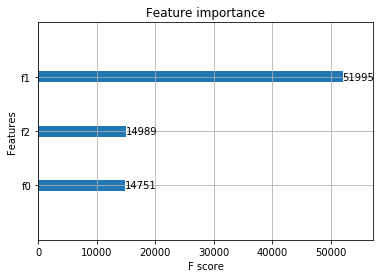

In [226]:
xgb.plot_importance(model);

In [281]:
cut = encoded_data[3010:3020] # Data for room "1"
y = cut.pop('room_id').values
x = cut.values

In [282]:
prediction = model.predict(x)
counts = np.bincount(prediction)
print('Prediction:', np.argmax(counts))

Prediction: 1


In [283]:
prediction

array([1, 3, 1, 1, 3, 6, 6, 1, 1, 1])